In [2]:
import numpy
import pylab
import nest

In [3]:
# We start with the global network parameters.


NE = 1000      # number of excitatory neurons
NI = 250       # number of inhibitory neurons
N = NE + NI    # total number of neurons
KE = 100       # excitatory in-degree
KI = 25        # inhibitory in-degree

In [4]:
neuron_model = 'iaf_psc_delta'
neuron_params = nest.GetDefaults(neuron_model)
Vmin = neuron_params['E_L']   # minimum of initial potential distribution (mV)
Vmax = neuron_params['V_th']  # maximum of initial potential distribution (mV)

In [5]:
J = 0.5                   # excitatory synaptic weight (mV)
g = 6.                    # relative inhibitory weight
delay = 0.1               # spike transmission delay (ms)


# External input parameters.


Jext = 0.2                # PSP amplitude for external Poisson input (mV)
rate_ext = 6500.          # rate of the external Poisson input


# Perturbation parameters.


t_stim = 400.             # perturbation time (time of the extra spike)
Jstim = Jext              # perturbation amplitude (mV)


# Simulation parameters.


T = 1000.                 # simulation time per trial (ms)
fade_out = 2.*delay       # fade out time (ms)
dt = 0.01                 # simulation time resolution (ms)
seed_NEST = 30            # seed of random number generator in Nest
seed_numpy = 30           # seed of random number generator in numpy

In [6]:
nest.ResetKernel()
nest.SetStatus([0], [{"resolution": dt}])

In [7]:
nodes_ex = nest.Create(neuron_model, NE)
nodes_in = nest.Create(neuron_model, NI)
allnodes = nodes_ex+nodes_in

nest.Connect(nodes_ex, allnodes,
             conn_spec={'rule': 'fixed_indegree', 'indegree': KE},
             syn_spec={'weight': J, 'delay': dt})
nest.Connect(nodes_in, allnodes,
             conn_spec={'rule': 'fixed_indegree', 'indegree': KI},
             syn_spec={'weight': -g*J, 'delay': dt})

In [8]:
ext = nest.Create("poisson_generator",
                  params={'rate': rate_ext, 'stop': T})
nest.Connect(ext, allnodes,
             syn_spec={'weight': Jext, 'delay': dt})

suppr = nest.Create("dc_generator",
                    params={'amplitude': -1e16, 'start': T,
                            'stop': T+fade_out})
nest.Connect(suppr, allnodes)

spikedetector = nest.Create("spike_detector")
nest.Connect(allnodes, spikedetector)

In [9]:
stimulus = nest.Create("spike_generator")
nest.SetStatus(stimulus, {'spike_times': []})

In [10]:
senders = []
spiketimes = []

In [11]:
for trial in [0, 1]:
    nest.ResetNetwork()
    nest.SetStatus([0], [{"rng_seeds": [seed_NEST]}])
    nest.SetStatus([0], {'time': 0.0})
    nest.SetStatus(spikedetector, {'n_events': 0})

    # We assign random initial membrane potentials to all neurons

    numpy.random.seed(seed_numpy)
    Vms = Vmin + (Vmax - Vmin) * numpy.random.rand(N)
    nest.SetStatus(allnodes, "V_m", Vms)

    if trial == 1:
        id_stim = [senders[0][spiketimes[0] > t_stim][0]]
        nest.Connect(stimulus, list(id_stim),
                     syn_spec={'weight': Jstim, 'delay': dt})
        nest.SetStatus(stimulus, {'spike_times': [t_stim]})

    # Now we simulate the network and add a fade out period to discard
    # remaining spikes.

    nest.Simulate(T)
    nest.Simulate(fade_out)

    # Storing the data.

    senders += [nest.GetStatus(spikedetector, 'events')[0]['senders']]
    spiketimes += [nest.GetStatus(spikedetector, 'events')[0]['times']]

/usr/lib/python3.8/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.


(0.0, 1250.0)

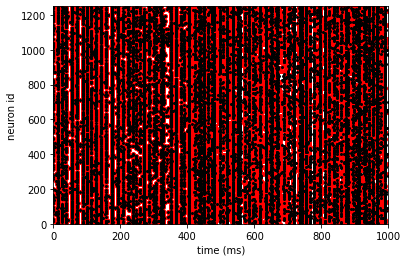

In [12]:
pylab.figure(1)
pylab.clf()
pylab.plot(spiketimes[0], senders[0], 'ro', ms=4.)
pylab.plot(spiketimes[1], senders[1], 'ko', ms=2.)
pylab.xlabel('time (ms)')
pylab.ylabel('neuron id')
pylab.xlim((0, T))
pylab.ylim((0, N))